In [1]:
"""
Created By    : Jared W. Marquis
Creation Date : 01 August 2022
Course        : ATSC 528 - Atmospheric Data Analysis
Assignment    : #03 - Statistical Objective Analysis

Purpose:
Script to take sparse upper air observations and analyze them on a
polar stereographic map projection using statistical objective analysis.
This is done by using either a bilinear or Barnes algorithm to plot the 
data (depending on location). Then, the distance is calculated between the 
grid points and the observation points, matrices are used to calculate the 
weights, and we plot it up! 

"""
__author__    = "Chuck Richie"
__contact__   = "charles.richie@und.edu"

In [19]:
### Import Required Modules (shouldn't need to change) ###
### Taking all the same from previous lab ###
import numpy as np                 #numpy for math
import matplotlib.pyplot as plt    #matplotlib for plotting
import cartopy.crs as ccrs         #cartopy for plotting on map
import cartopy.feature as cfeature #cartopy basic shapefiles
import os
import csv
import pandas as pd


[25.14618727 22.16243723 26.09166841 19.46031159 17.09435424 14.40009368
  6.05286737 14.41403809 12.72077995 16.56021129  3.13233218 22.9844841
 17.86946558 25.02010166  9.98386075 19.32921878 21.19078682 12.33740597
 15.56359807 17.00061122 21.91727344 20.69378516 15.21940721 27.66549619
 18.88775062 25.58945811 40.77215157 31.11193619 18.20292178 29.99626054
 16.61476878 36.03678903 25.4365251  39.95507791 16.68750546 23.93847959
 27.60913213 40.48370863 14.14239876 30.43077713 36.90049707 35.42337811
 33.98640991 47.2983383   9.7434409  27.82000918 36.59335702 21.36278411
 16.71589771 25.13375191 35.32369272 45.62464832 37.51151039 36.47830578
 44.9056349  43.6613456  36.55621593 44.94531637 29.5622763  32.39696588
 43.58871899 42.56808786 14.87917442 36.79320191 40.99223651 35.69700052
 41.03504331 29.92469305 37.45071921 29.65333733 32.9824296  23.96021466
 29.98482233 32.0239038  32.99049755 27.84813015 42.73377124 39.55454532
 37.86100219 37.48060231 38.96822223 34.87931338 42.

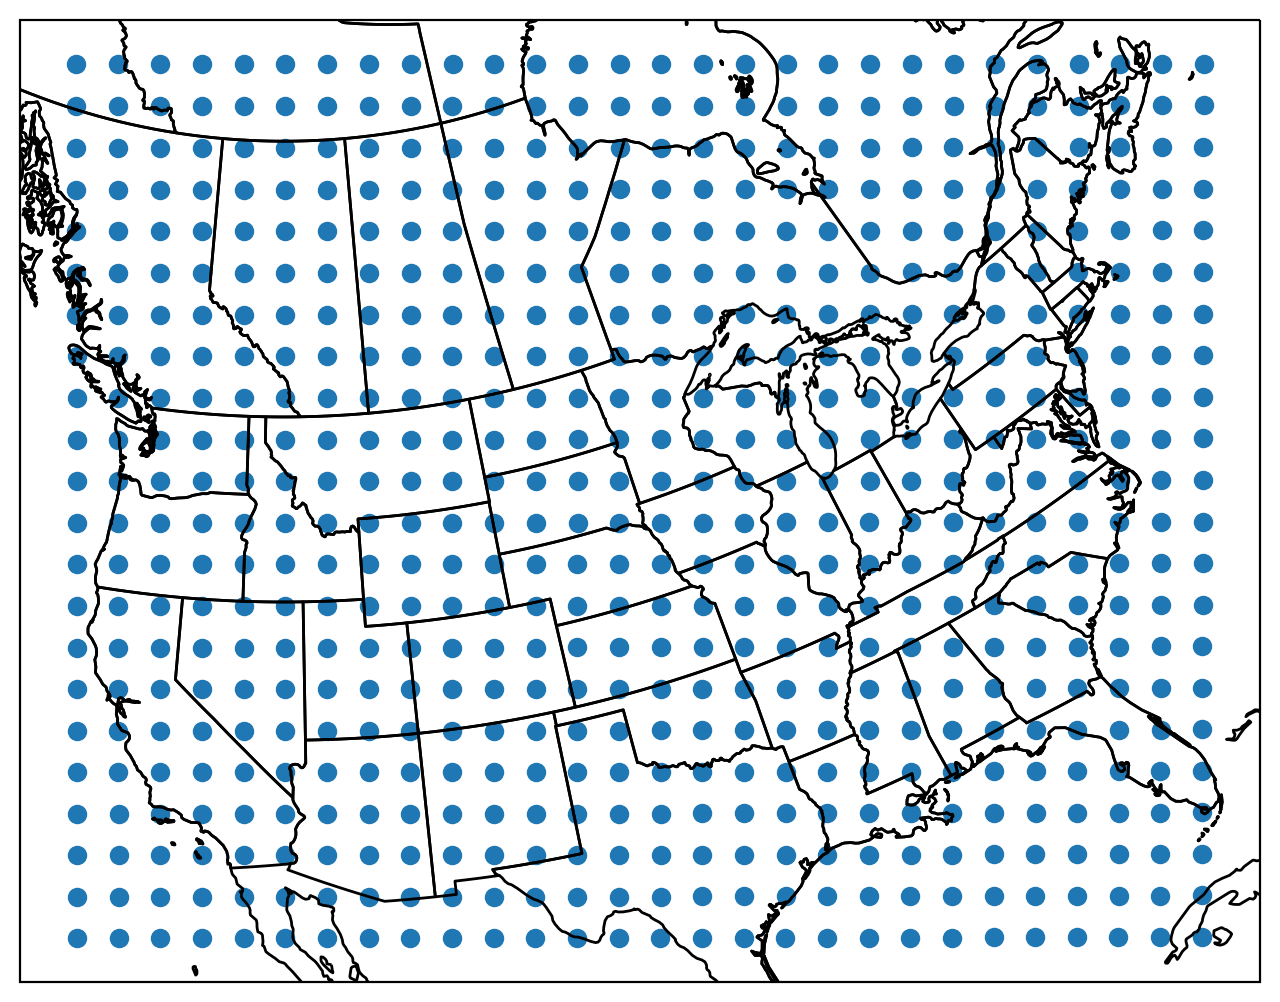

In [20]:
### As previously, reading in data and setting up the analysis grid ###
## Giant block of code, but it is all from previous labs, and makes less cells to click on ##

### Read in observations ###
### Still the same ###
file = open('RAOBs_201903131200.txt')
csvreader = csv.reader(file)
rows = []
for row in csvreader:
    rows.append(row)
rows


list_title = rows
df = pd.DataFrame(list_title, columns= ['Station ID', 'Lat', 'Long', '500 mb Height', '500 mb Wind Dir', '500 mb Wind Speed'])
obs_long = df['Long'].astype(float)
obs_lat = df['Lat'].astype(float)
### Now to make this in radians ###
obs_long_rad = obs_long*(np.pi/180)
obs_lat_rad = obs_lat*(np.pi/180)
height = df['500 mb Height'].astype(float)
height = np.array(height)

### Set up analysis map with a 22x28 rectangular grid of points ###
### This too ###
xo= 18.9
yo= -6.3
deltax= 1.27
deltay= 1.27

map_proj= 1/15e6
rho= 6371 * 1e5
lambdao= -115
psio= 60 * (np.pi/180)

x = np.arange(start = xo, stop = (deltax*22+18.9) -1, step = deltax)
y = np.arange(start = yo, stop = (deltay*28+-6.3)-1, step = deltay)

grid_x, grid_y = np.meshgrid(x,y)

### convert obs lat/long to x,y ###
### Setting up the x,y as a Long/Lat Respectively ###
lons = np.arctan((grid_y/grid_x))*(180/(np.pi)) + lambdao
psi= (180/(np.pi))*(((np.pi)/2)-(2*(np.arctan((np.sqrt((grid_x/map_proj)**2 + (grid_y/map_proj)**2))/(rho*(1 + np.sin(psio)))))))

## Well, might as well plot this map ###
proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

ax1.scatter(lons.ravel(), psi.ravel(), transform = ccrs.PlateCarree())


### Now to get fancy with the equations from the NOAA Appendix. NOAA FTW ###

### Starting with the scale factor ###

sigma = (1+np.sin(psio))/(1+np.sin(obs_lat_rad))

###  Next to determine any latitude circle radii ###

radius = rho*sigma*(np.cos(obs_lat_rad))

### And finally latitude difference from the standard latitude ###

obs_lambda = ((obs_long_rad)-(lambdao*(np.pi/180)))

### Now to do x and y for observations, then lat/long those bad boys ###

obs_x = rho*sigma*(np.cos(obs_lat_rad))*(np.cos(obs_lambda))*map_proj
obs_y = rho*sigma*(np.cos(obs_lat_rad))*(np.sin(obs_lambda))*map_proj

obs_x = np.array(obs_x)
obs_y = np.array(obs_y)

### Testing ###

print (obs_x)
print (obs_y)

obs_long = np.arctan(obs_y/obs_x)*(180/np.pi)+lambdao
obs_lat = (180/(np.pi))*(((np.pi)/2)-(2*(np.arctan((np.sqrt((obs_x/map_proj)**2 + (obs_y/map_proj)**2))/(rho*(1 + np.sin(psio)))))))

### Will it work??? That's debatable... ###

print(obs_long)
print("Break Break Break Break Break Break Break Break Break")
print(obs_lat)
### IF this previuos code looks familiar, I reused a lot from lab 1, including comments ###


In [21]:
### Create function for Barnes Analysis ###

re = 12.7775892
Kd = 10.8844524
ROI_array = np.array([re])

def barnes(dik):
    
    wdik = np.exp((-dik**2)/Kd)
    
    return wdik

In [22]:
### Create function for bilinear interpolation ###
## Or in this case, correct the bilinear function from the previous lab ##
def bilinear(x,y):
    
    delx = x - int(np.floor(x))
    dely = y - int(np.floor(y))
    Z1 = back_mat[int(np.floor(y)), int(np.floor(x))]
    Z2 = back_mat[int(np.ceil(y)), int(np.floor(x))]
    Z3 = back_mat[int(np.ceil(y)), int(np.ceil(x))]
    Z4 = back_mat[int(np.floor(y)), int(np.ceil(x))]
    
    p = (((delx-1)*(dely-1)*Z1)-((delx)*(dely-1)*Z2)+((delx)*(dely)*Z3)-((delx-1)*(dely)*Z4))
    
    ### Since delta (x,y) are in a space of (1,0), 1 / delta x * delta y always will be 1, thus not included at start of p equation ###
    ### It is also the reason that x and y have 1 subtracted from some, and not the others (subtraction of 0 and 1 in a (0,1) world) ###
    return p

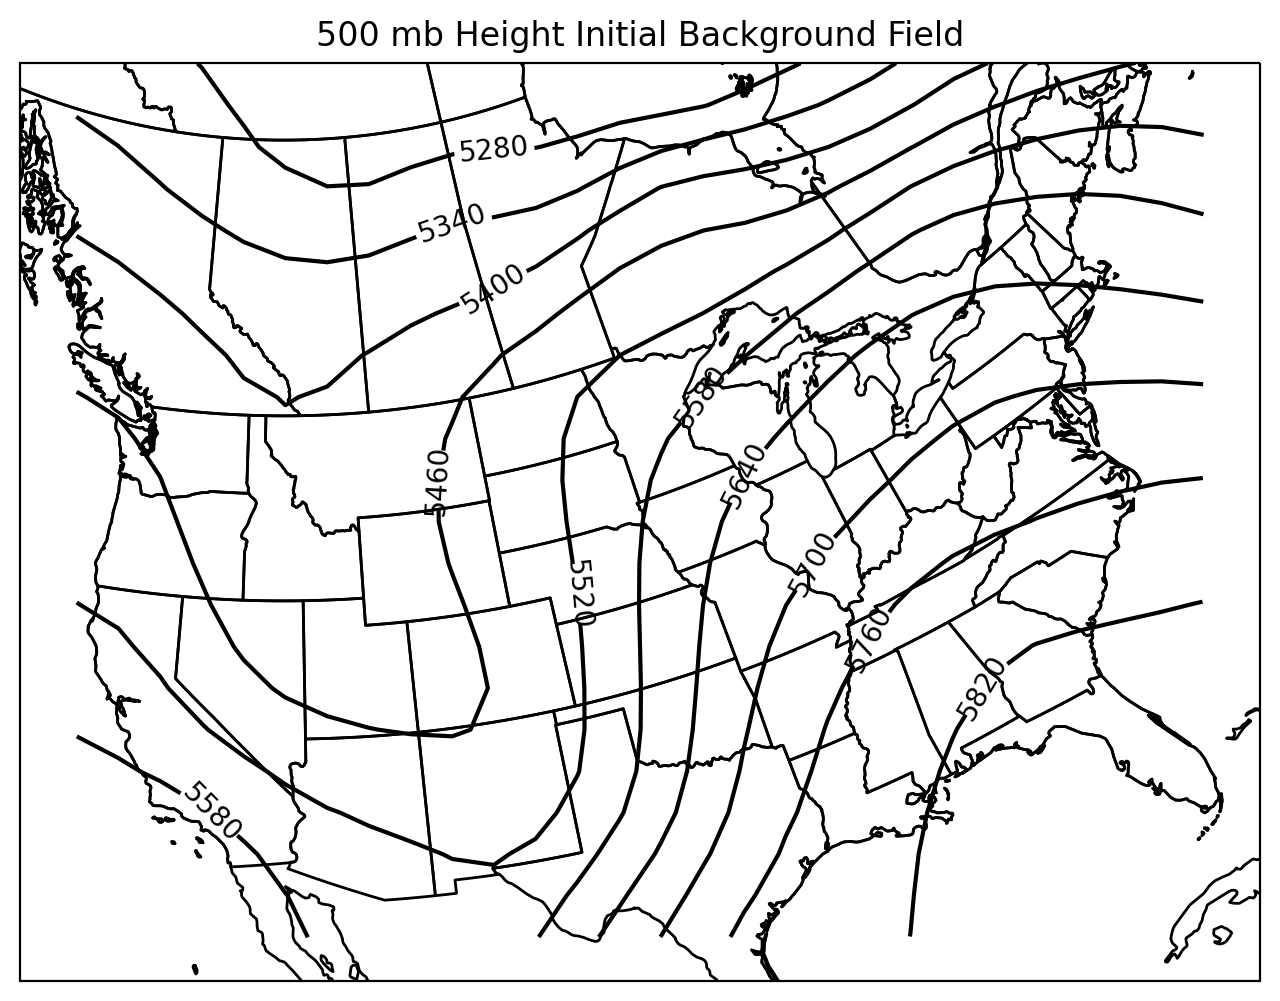

In [23]:
### First analysis, no successive corrections ###
### To quote my former drill instructor "HEEEEEEERE WE GO!" ###



y_cols = 28
x_rows = 22

an_mat = np.empty((y_cols, x_rows, 3))
back_mat = np.empty((y_cols, x_rows))


for i in range(len(grid_x)):
    for j in range(len(grid_x[0])):
        xr = grid_x[i,j]-obs_x # distance in x direction #
        yr = grid_y[i,j]-obs_y # distance in y direction #
        # Now to make sure my data is within the bounds of the Radius of Influence (ROI) #
        rad = ((xr**2 + yr**2)**0.5) # Yes, I understand the exponents #
        index_ROI = np.where(rad <= ROI_array)[0]
        # Now to weight the analysis matrix #
        
        x_k = xr[index_ROI]
        y_k = yr[index_ROI]
        fo = height[index_ROI] 
        w_mat = np.zeros(len(index_ROI))
        for k in range(len(index_ROI)):
            rel_rad = (x_k[k] **2 + y_k[k]**2)**0.5
            w = barnes(rel_rad)
            w_mat[k] = w
        ### Since I had defined height as the previous term, I am now calling it fo to help me visualize the equation #
        back_mat[i,j] = np.sum(w_mat * fo)/np.sum(w_mat)
        
        
### Wow...that was harder than it looks if you program like I do. Also to quote my former drill instructor again "...Amazing." ###
### Plot 500mb analyses over a map ###
#convert analysis x,y to lat/lon#


proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
# Did that. Changed the variables to my variables. #
cs1 = ax1.contour(lons,psi,back_mat[:,:],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("500 mb Height Initial Background Field")
plt.show()



In [7]:
#back_mat[:,:] #just testing data here #

In [24]:
### Forward interpolation part of the lab ###
### We want the background values at the observation locations, not just the analysis locations ###
### Time to stop bellyaching and set up the data to make things work bilinearly or not...###

indy = ((obs_y - yo)/deltay) # Nod of respect to the great Indiana Jones #
indx = ((obs_x - xo)/deltax)

result = np.zeros(len(obs_x))

### Same loop from Lab 2. Well different but same...(comments mostly same, lol) if the analysis point is inside the grid ###
### then do the bilinear approach. If it is not in the grid, but in the ROI, then use a Barnes analysis. If it is neither, ignore that shizz ###
### Coding it on the other hand, well....### 

for i in range(len(indx)):
    if (indx[i] >= 0) and (indx[i] < 21) and (indy[i] >= 0) and (indy[i] < 27):
        p = bilinear(indx[i], indy[i])
    else:
        x_an = obs_x[i] - grid_x
        y_an = obs_y[i] - grid_y
        rad_an = np.sqrt((x_an**2) + (y_an**2))
        anvil = np.where(rad_an <= ROI_array[0]) # I was going to call this an_val, but it looked like anvil....I miss thunderstorms...# 
        w_an = np.zeros(grid_x.shape)
                        
        for j in anvil[0]:
            for k in anvil[1]:
                barnes_an = barnes(rad_an[j,k])
                w_an[j,k] = barnes_an
        p = np.nansum(w_an * back_mat[:,:])/np.nansum(w_an)

    result[i] = p 
                    
        
# Hey what do you know? Correcting code from lab 2 bilinear function fixes this! # 

C:\Users\Chuck\AppData\Local\Temp\ipykernel_16728\500435628.py:28: RuntimeWarning: invalid value encountered in double_scalars
  p = np.nansum(w_an * back_mat[:,:])/np.nansum(w_an)


In [9]:
result #code testing as there were lots of previous issues...see lab 2 #

array([5461.88050834, 5538.24550379, 5356.11734678, 5330.0878094 ,
       5247.31677759, 5240.8625331 ,           nan, 5299.80077822,
       5259.95879988, 5470.5629805 ,           nan, 5456.45714116,
       5295.78850635, 5378.02537342, 5234.52218771, 5491.52330485,
       5257.99100814, 5237.86964879, 5321.44423797, 5295.7640613 ,
       5329.59134772, 5260.59802189, 5416.31057752, 5429.26441256,
       5456.61275952, 5388.30240214, 5489.79496161, 5542.0648065 ,
       5333.35040465, 5704.81935078, 5327.40387652, 5474.82512695,
       5644.78543997, 5539.3110483 , 5325.66305166, 5381.78625486,
       5640.05623888, 5765.79337407, 5322.11672072, 5507.89936286,
       5808.84376373, 5768.78719617, 5418.64717119, 5765.06859405,
       5311.82849902, 5670.8416495 , 5752.83737012, 5527.71059297,
       5323.90057072, 5623.98598525, 5800.74406057, 5745.92435093,
       5541.04166056, 5485.4117143 , 5678.3787066 , 5537.63757244,
       5486.81252769, 5676.32835474, 5672.22094975, 5660.92385

In [25]:
### Buliding the function for the Schlatter method ###

def schlatter(dik):    
    
    
    if dik == 0:
        rhodik = 1
    else:
        rhodik = 0.95*(np.exp(((1+np.sin(40*(np.pi/180)))/(1+np.sin(60*(np.pi/180))))*-1.24*(dik**2)))
    return rhodik
    
    # Have to add in the sin function since this is on a globe, and we need to do some conversions#

In [26]:
## Time to build some matrices and do matrix magic. Also loops on loops on loops. #
# There are several lines of cocde that are commented out as there was testing along may steps #
# Leaving those in to show the QA process and troubleshooting steps along the way #

distkm = []
def matrices(N, num_n):
    rho_matrix = np.zeros([N,N])
    rhoi_matrix = np.zeros([N])
    w_matrix = np.zeros([N])
    
    
    for i in range(len(grid_x)):
        for j in range(len(grid_x[0])):
            d=[]
            
            x_diff = (obs_x - grid_x[i,j])
            y_diff = (obs_y - grid_y[i,j])
    
            distcm = np.sqrt((x_diff**2)+(y_diff**2))
            vals = np.argsort(distcm)[0:N]
            #print(vals) #Finding the nearest ob to each grid point so we can expand it to the required matrix size later (grabbing nearest points) #
            
            obs = height[vals]
            x_k = obs_x[vals]
            y_k = obs_y[vals]
            #print(vals)
            for k in range(len(vals)):
                for m in range(len(vals)):
                     # I am running out of things to call a difference, delta etc #
                        # G comes after F, so screw it dif becomes dig #
                        
                    x_dig = x_k[m] - x_k[k]
                    y_dig = y_k[m] - y_k[k]
                    
                    distdig = np.sqrt((x_dig**2)+(y_dig**2))
                    s = distdig/map_proj
                    dist_km = s/(1000*1000*100)
                    rho_s = schlatter(dist_km)
                    rho_matrix[k,m] = rho_s
            rho_matrix = np.linalg.inv(np.matrix(rho_matrix)) #Inverting now to save time later # 
            
            for n in range(len(vals)):
                #Same Here. H follows G, hence dih #
                
                x_dih = x_k[n] - grid_x[i,j]
                y_dih = y_k[n] - grid_y[i,j]
                
                distdih = np.sqrt((x_dih**2)+(y_dih**2))
                q = distdih/map_proj
                dist_km = q/(1000*1000*100)
                
                rhoq = schlatter(dist_km)
                rhoi_matrix[n] = rhoq
                
            #print(rhoi_matrix)
            w_matrix = np.matrix(rhoi_matrix)*rho_matrix #Matrix multiplication FTW # 
            
            #print(w_matrix)
            
            RHS = np.zeros((N))
            for p in range(len(vals)): 
                RHS[p] = w_matrix[0,p] * (height[vals[p]] - result[vals[p]])
            an_mat[i,j,num_n] = back_mat[i,j] + (np.sum(RHS))
     
            


In [27]:
N = [2,4,10]
for ns in range(len(N)):
    n = N[ns]
    matrices(n, ns)

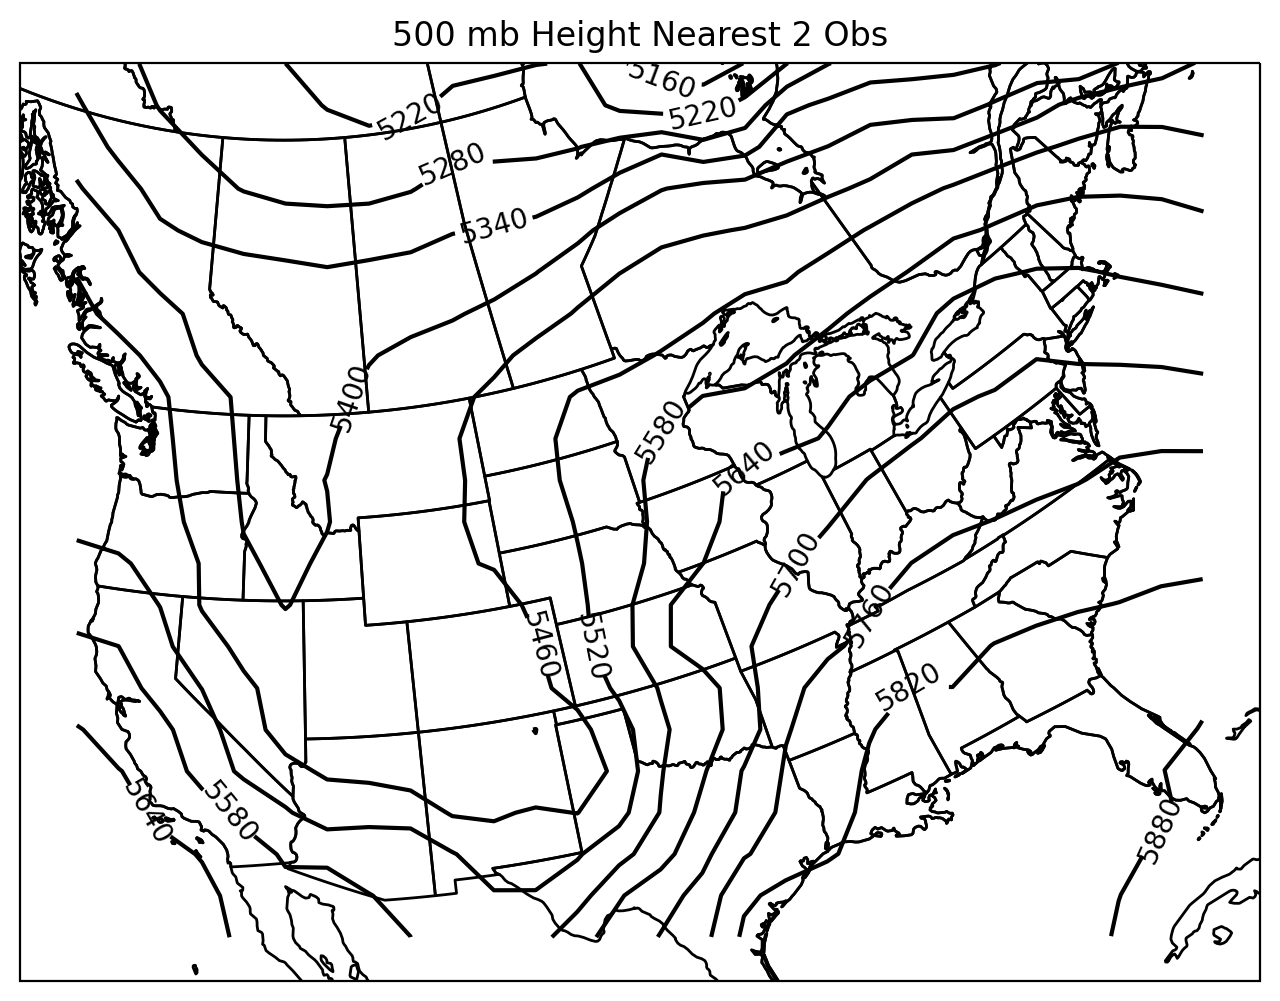

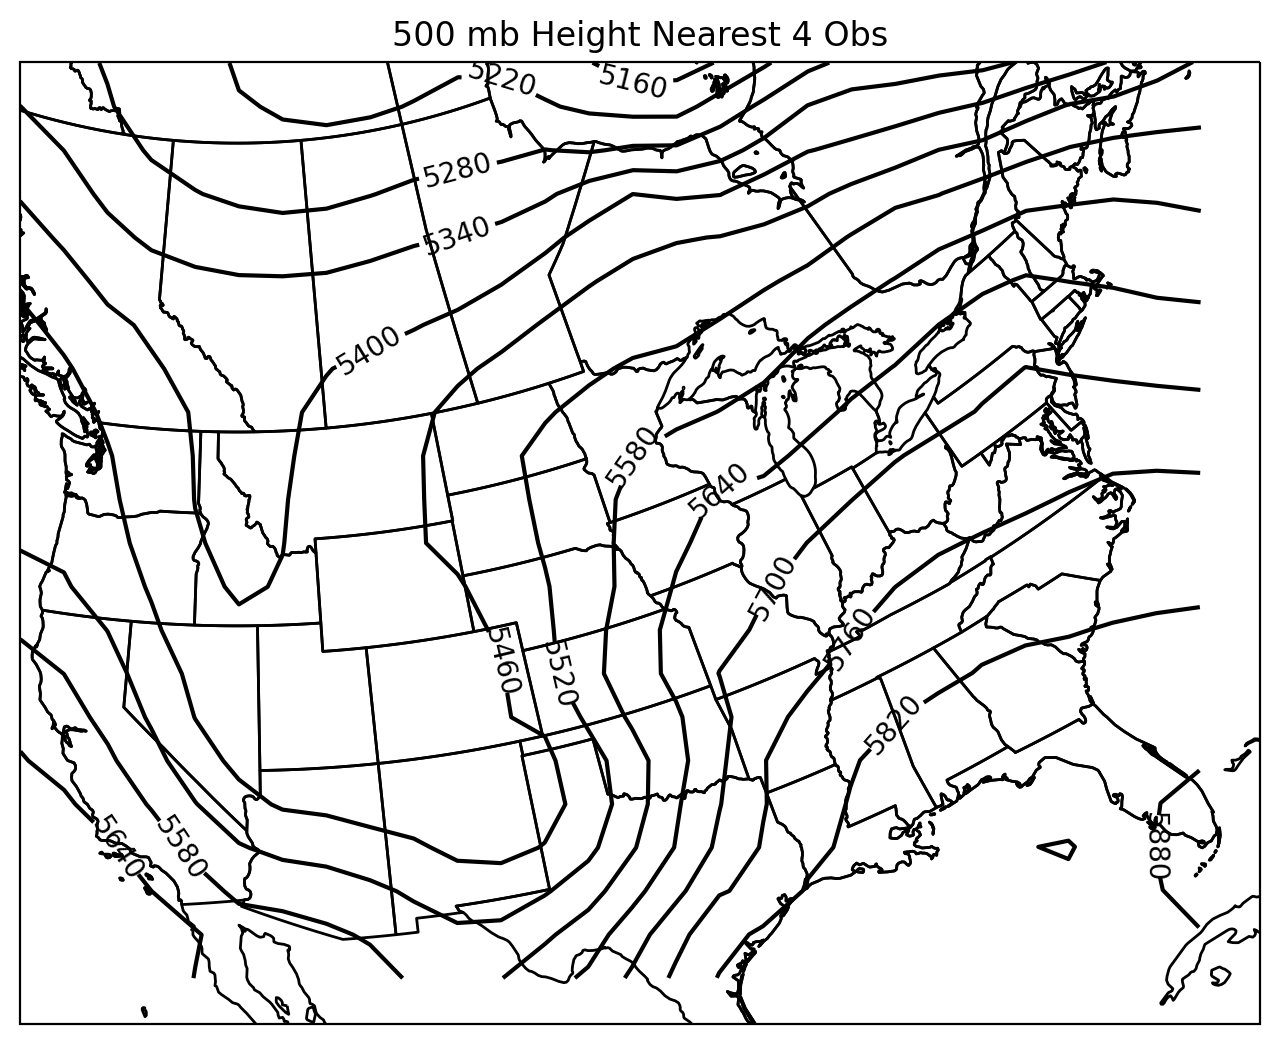

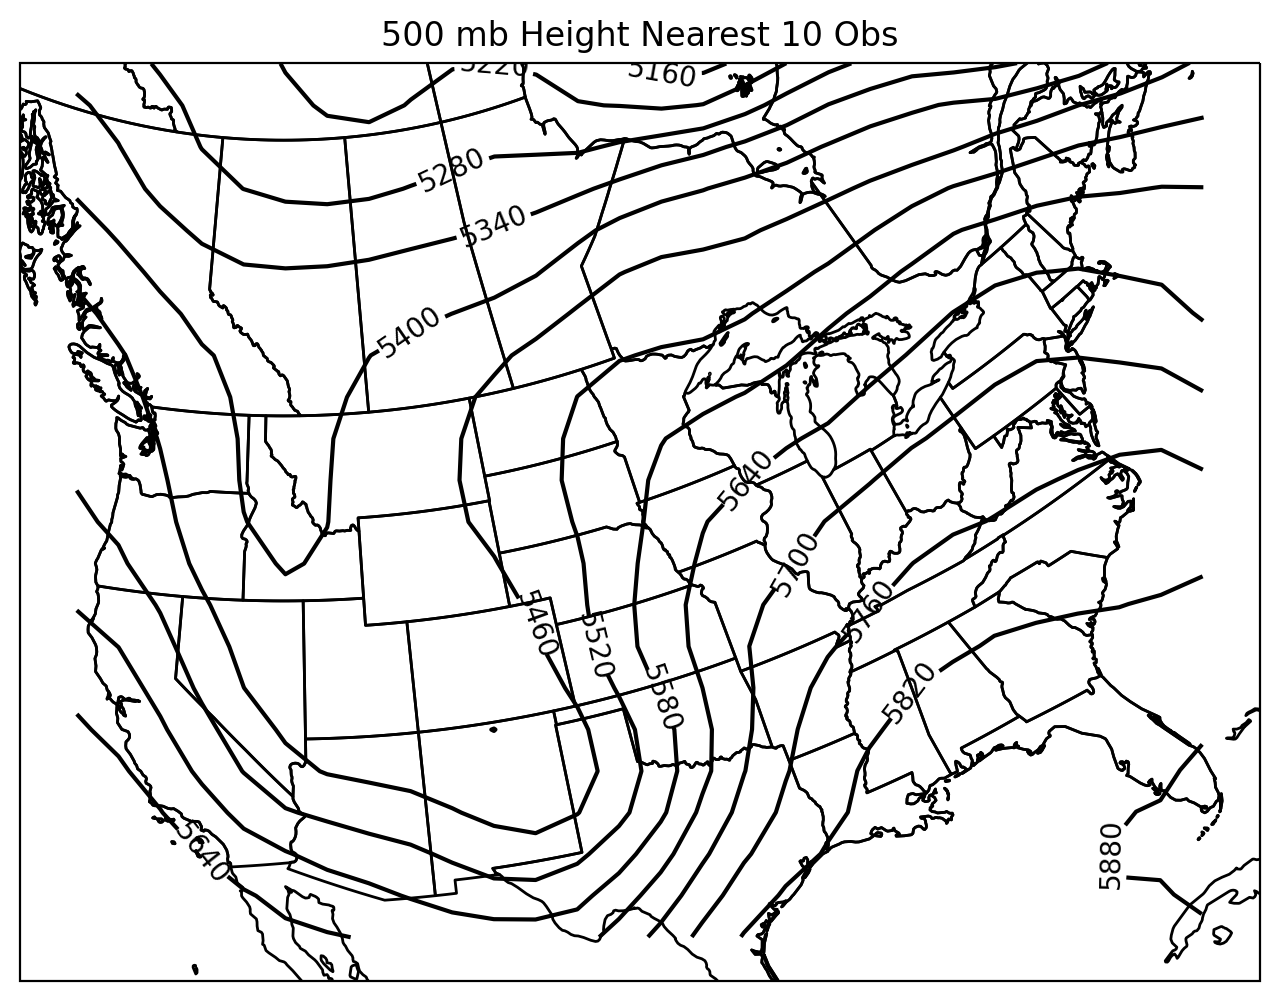

In [28]:
# Plotting them all up. Just using 1 box here for all the maps #

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
# Did that. Changed the variables to my variables. #
cs1 = ax1.contour(lons,psi,an_mat[:,:,0],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("500 mb Height Nearest 2 Obs")
plt.show()

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
# Did that. Changed the variables to my variables. #
cs1 = ax1.contour(lons,psi,an_mat[:,:,1],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("500 mb Height Nearest 4 Obs")
plt.show()

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
# Did that. Changed the variables to my variables. #
cs1 = ax1.contour(lons,psi,an_mat[:,:,2],colors='k',levels=np.arange(0,8000,60),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(0,8000,60))
plt.title("500 mb Height Nearest 10 Obs")
plt.show()


In [29]:
#Saving the analysis matrices # 
np.savetxt("AnalysisMatrix1.txt", an_mat[:,:,0], delimiter=',')
np.savetxt("AnalysisMatrix2.txt", an_mat[:,:,1], delimiter=',')
np.savetxt("AnalysisMatrix3.txt", an_mat[:,:,2], delimiter=',')


In [30]:
# Calculating the Analysis increments and saving them. #

an_inc1 = an_mat[:,:,0] - back_mat[:,:]

an_inc2 = an_mat[:,:,1] - back_mat[:,:]

an_inc3 = an_mat[:,:,2] - back_mat[:,:]

np.savetxt("AnalysisIncrement1.txt", an_inc1, delimiter=',')
np.savetxt("AnalysisIncrement2.txt", an_inc2, delimiter=',')
np.savetxt("AnalysisIncrement3.txt", an_inc3, delimiter=',')

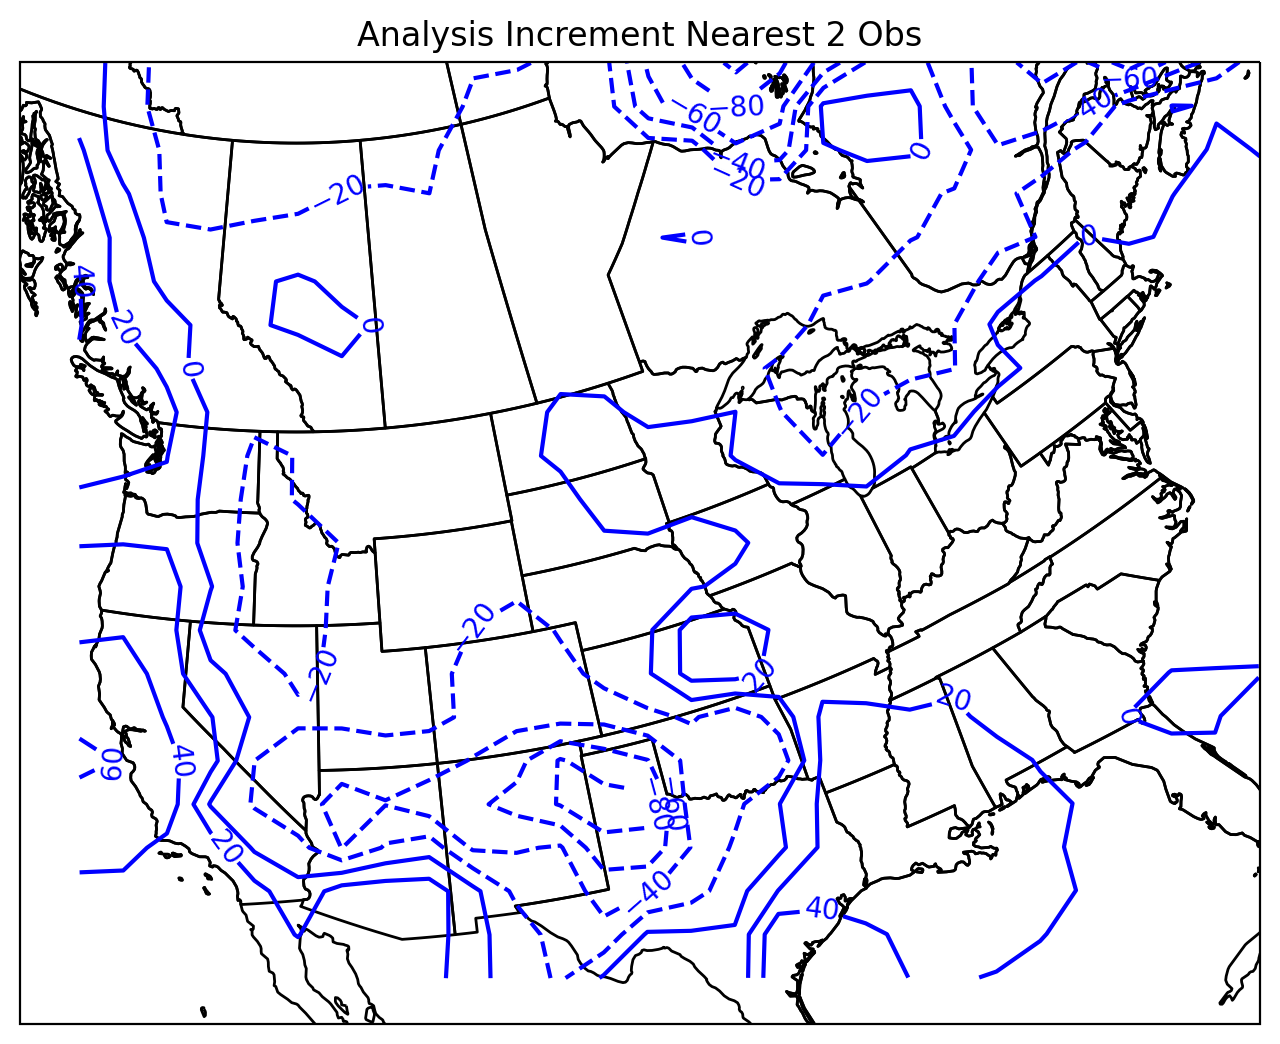

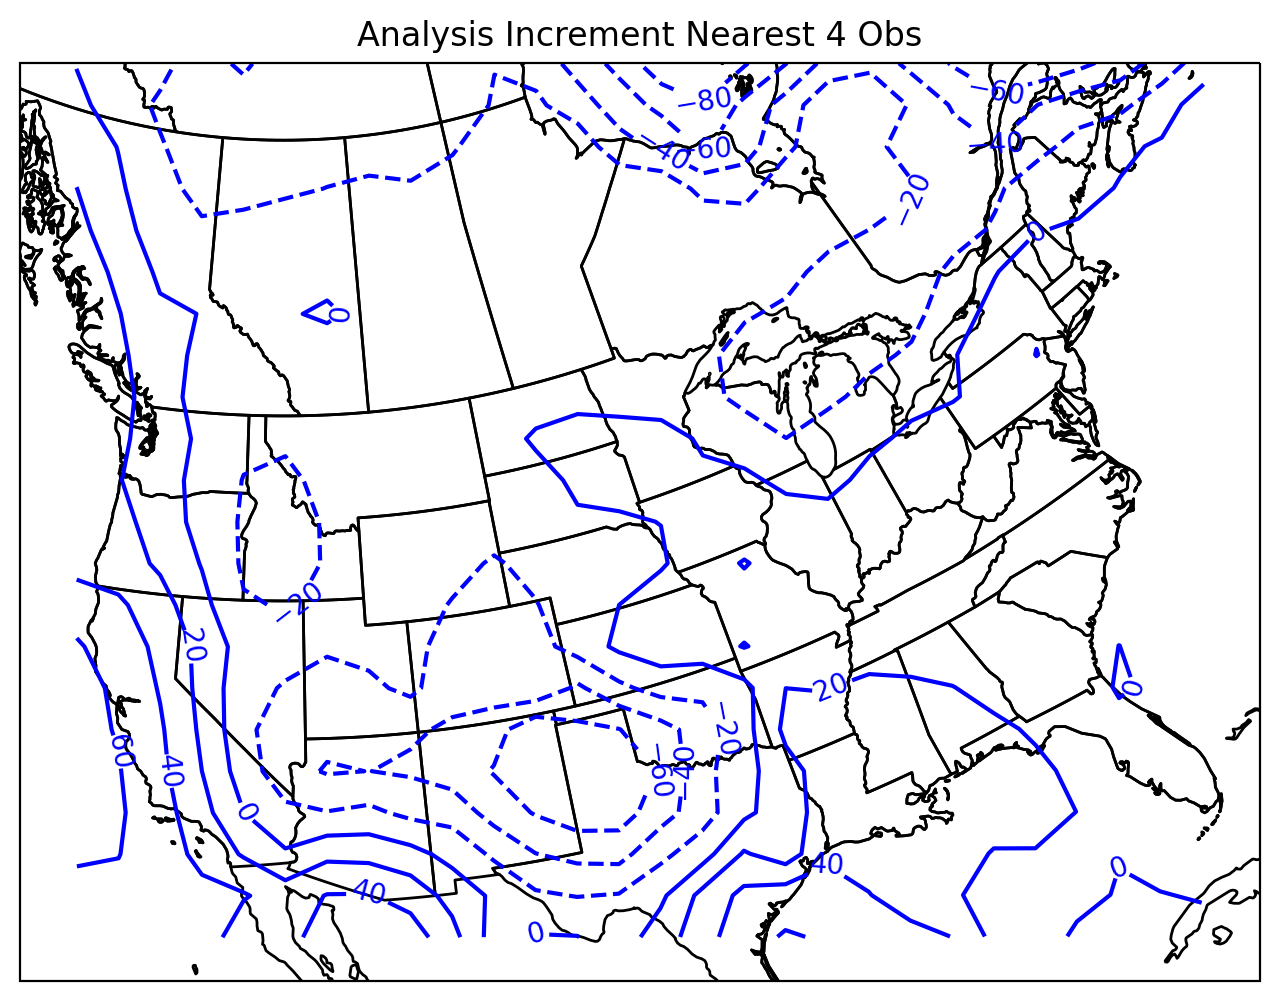

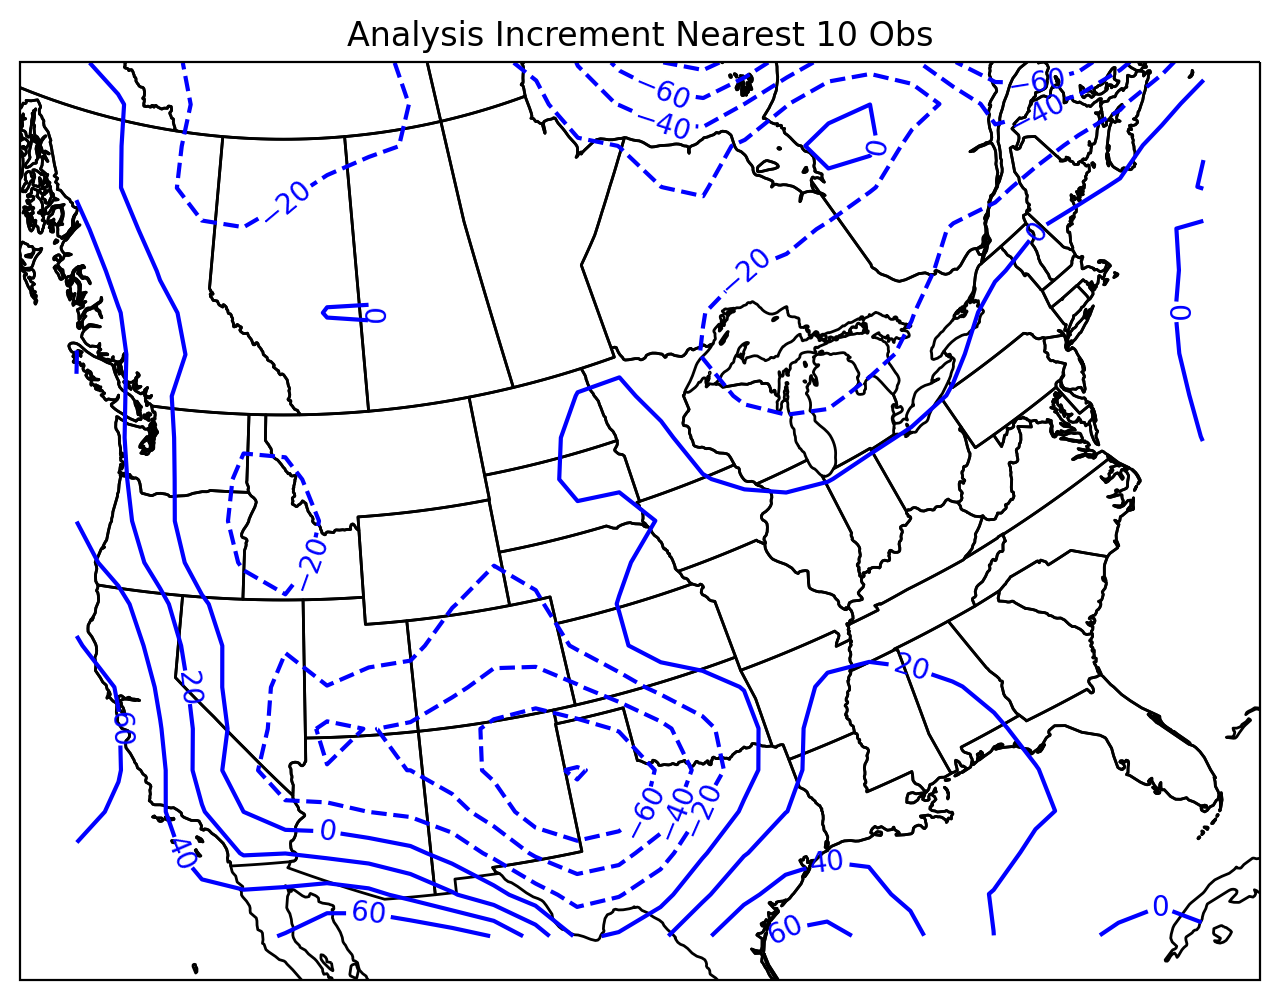

In [31]:
# Plotting the Analyis increments. Just using another big block of code. #

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
# Did that. Changed the variables to my variables. #
cs1 = ax1.contour(lons,psi,an_inc1,colors='b',levels=np.arange(-200,200,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-200,200,20))
plt.title("Analysis Increment Nearest 2 Obs")
plt.show()

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
# Did that. Changed the variables to my variables. #
cs1 = ax1.contour(lons,psi,an_inc2,colors='b',levels=np.arange(-200,200,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-200,200,20))
plt.title("Analysis Increment Nearest 4 Obs")
plt.show()

proj = ccrs.Stereographic(central_longitude=-115,central_latitude=90,true_scale_latitude=60)
fig = plt.figure(figsize=(8,8),dpi=200)
ax1 = fig.add_subplot(111,projection=proj)
ax1.add_feature(cfeature.STATES)
ax1.add_feature(cfeature.COASTLINE)

#plot analysis (MAY NEED TO CHANGE VARIABLE NAMES/INDICES)#
# Did that. Changed the variables to my variables. #
cs1 = ax1.contour(lons,psi,an_inc3,colors='b',levels=np.arange(-200,200,20),transform=ccrs.PlateCarree())
plt.clabel(cs1,levels=np.arange(-200,200,20))
plt.title("Analysis Increment Nearest 10 Obs")
plt.show()

In [35]:
# To forward interpolate the analysis matrix, I need a bilinear function WRT N #

def bilinear2(x,y,N):
    
    delx = x - int(np.floor(x))
    dely = y - int(np.floor(y))
    Z1 = an_mat[int(np.floor(y)), int(np.floor(x)), N]
    Z2 = an_mat[int(np.ceil(y)), int(np.floor(x)), N]
    Z3 = an_mat[int(np.ceil(y)), int(np.ceil(x)), N]
    Z4 = an_mat[int(np.floor(y)), int(np.ceil(x)), N]
    
    q = (((delx-1)*(dely-1)*Z1)-((delx)*(dely-1)*Z2)+((delx)*(dely)*Z3)-((delx-1)*(dely)*Z4))
    
    ### Since delta (x,y) are in a space of (1,0), 1 / delta x * delta y always will be 1, thus not included at start of p equation ###
    ### It is also the reason that x and y have 1 subtracted from some, and not the others (subtraction of 0 and 1 in a (0,1) world) ###
    return q

In [36]:
# Forward interpoloation of the analysis matrices to calculate analysis difference #

# Starting with Nearest 2 Obs #

indy = ((obs_y - yo)/deltay) # Nod of respect to the great Indiana Jones #
indx = ((obs_x - xo)/deltax)

result2 = np.zeros(len(obs_x))

### Same loop from Lab 2. Well different but same...(comments mostly same, lol) if the analysis point is inside the grid ###
### then do the bilinear approach. If it is not in the grid, but in the ROI, then use a Barnes analysis. If it is neither, ignore that shizz ###
### Coding it on the other hand, well....### 

for i in range(len(indx)):
    if (indx[i] >= 0) and (indx[i] < 21) and (indy[i] >= 0) and (indy[i] < 27):
        p = bilinear2(indx[i], indy[i], 0)
    else:
        x_an = obs_x[i] - grid_x
        y_an = obs_y[i] - grid_y
        rad_an = np.sqrt((x_an**2) + (y_an**2))
        anvil = np.where(rad_an <= ROI_array[0]) # I was going to call this an_val, but it looked like anvil....I miss thunderstorms...# 
        w_an = np.zeros(grid_x.shape)
                        
        for j in anvil[0]:
            for k in anvil[1]:
                barnes_an = barnes(rad_an[j,k])
                w_an[j,k] = barnes_an
        p = np.nansum(w_an * an_mat[:,:,0])/np.nansum(w_an)

    result2[i] = p 
    
# Now for nearest 4 #

indy = ((obs_y - yo)/deltay) # Nod of respect to the great Indiana Jones #
indx = ((obs_x - xo)/deltax)

result4 = np.zeros(len(obs_x))

### Same loop from Lab 2. Well different but same...(comments mostly same, lol) if the analysis point is inside the grid ###
### then do the bilinear approach. If it is not in the grid, but in the ROI, then use a Barnes analysis. If it is neither, ignore that shizz ###
### Coding it on the other hand, well....### 

for i in range(len(indx)):
    if (indx[i] >= 0) and (indx[i] < 21) and (indy[i] >= 0) and (indy[i] < 27):
        p = bilinear2(indx[i], indy[i], 1)
    else:
        x_an = obs_x[i] - grid_x
        y_an = obs_y[i] - grid_y
        rad_an = np.sqrt((x_an**2) + (y_an**2))
        anvil = np.where(rad_an <= ROI_array[0]) # I was going to call this an_val, but it looked like anvil....I miss thunderstorms...# 
        w_an = np.zeros(grid_x.shape)
                        
        for j in anvil[0]:
            for k in anvil[1]:
                barnes_an = barnes(rad_an[j,k])
                w_an[j,k] = barnes_an
        p = np.nansum(w_an * an_mat[:,:,1])/np.nansum(w_an)

    result4[i] = p 
    
# And last but not least, nearest 10 obs #

indy = ((obs_y - yo)/deltay) # Nod of respect to the great Indiana Jones #
indx = ((obs_x - xo)/deltax)

result10 = np.zeros(len(obs_x))

### Same loop from Lab 2. Well different but same...(comments mostly same, lol) if the analysis point is inside the grid ###
### then do the bilinear approach. If it is not in the grid, but in the ROI, then use a Barnes analysis. If it is neither, ignore that shizz ###
### Coding it on the other hand, well....### 

for i in range(len(indx)):
    if (indx[i] >= 0) and (indx[i] < 21) and (indy[i] >= 0) and (indy[i] < 27):
        p = bilinear2(indx[i], indy[i], 2)
    else:
        x_an = obs_x[i] - grid_x
        y_an = obs_y[i] - grid_y
        rad_an = np.sqrt((x_an**2) + (y_an**2))
        anvil = np.where(rad_an <= ROI_array[0]) # I was going to call this an_val, but it looked like anvil....I miss thunderstorms...# 
        w_an = np.zeros(grid_x.shape)
                        
        for j in anvil[0]:
            for k in anvil[1]:
                barnes_an = barnes(rad_an[j,k])
                w_an[j,k] = barnes_an
        p = np.nansum(w_an * an_mat[:,:,2])/np.nansum(w_an)

    result10[i] = p 

C:\Users\Chuck\AppData\Local\Temp\ipykernel_16728\2972072624.py:28: RuntimeWarning: invalid value encountered in double_scalars
  p = np.nansum(w_an * an_mat[:,:,0])/np.nansum(w_an)
C:\Users\Chuck\AppData\Local\Temp\ipykernel_16728\2972072624.py:57: RuntimeWarning: invalid value encountered in double_scalars
  p = np.nansum(w_an * an_mat[:,:,1])/np.nansum(w_an)
C:\Users\Chuck\AppData\Local\Temp\ipykernel_16728\2972072624.py:86: RuntimeWarning: invalid value encountered in double_scalars
  p = np.nansum(w_an * an_mat[:,:,2])/np.nansum(w_an)


In [38]:
# Calculating the Analysis difference (analysis - observation)  and calculating RMS values and saving #

D1 = (height - result2)**2
D1 = D1[~np.isnan(D1)]
RMS1 = np.sqrt(np.sum(D1)/len(D1))
#print(D1)
print(RMS1)

D2 = (height - result4)**2
D2 = D2[~np.isnan(D2)]
RMS2 = np.sqrt(np.sum(D2)/len(D2))
#print(D2)
print(RMS2)

D3 = (height - result10)**2
D3 = D3[~np.isnan(D3)]
RMS3 = np.sqrt(np.sum(D3)/len(D3))
#print(D3)
print(RMS3)

RMSfinal = np.array((RMS1, RMS2, RMS3))
np.savetxt("RMS.txt", RMSfinal, delimiter=',')
               
np.savetxt("AnalysisDifference2.txt", D1, delimiter=',')
np.savetxt("AnalysisDifference4.txt", D2, delimiter=',')
np.savetxt("AnalysisDifference10.txt", D3, delimiter=',')




51.91433649812185
49.958482307273734
50.97047031219863


In [ ]:
### In a separte text file (or below), answer the following questions ###
'''
1 - Describe the general features that you see in your contoured analyses.
    General features remain the same. There is a trough over the western United States and slight ridging over the Midwest/eastern United States. The 5400 line protrudes farther 
    south in the later runs compared to the background run. 

2 - Describe the differences that you see in your contoured analyses.  
    Does one analysis seem to be smoother than the other?  If so, what would cause this?
    Notably, the 5880 line over Florida keeps changing shape with different runs. The 5400 line is further south in the 2 obs run, but further north in the 4 and 10 ob runs.
    Additionally, there is a small ridging feature over eastern Kansas in the 2 ob run that is smoothed out in the other runs. 
    The run with the nearest 10 observations appears to be the smoothest overall. This is likley due to the fact that as you increase the number of observations that are weighed in, 
    you are increasing the distance covered by a sample. This will average the data out over a larger area and smooth out smaller scale features. 

3 - What happens as you increase the number of points considered for the analysis?  Is this 
    desirable?  Why or why not?
    Hinted at a bit above. Since we wrote the code to consider the nearest N points, as you increase the amount of points sampled, you increase the area of influence. At a smaller N, such as 
    2, the closest observations are weighted more heavily, resolving some smaller scale features. As you increase the number of points to weigh in, the area of coverage increases. This can 
    smooth out smaller scale features, as there is more data over which to run the calculation. The desireability really depends on what you are wanting to examine. If you want to resolve the 
    small scale features, then it is not desireable. If you only want to consider large scale flows, then it is somewhat desireable. There is likley a nice balance somewhere in between. 
    
'''